### Final Model function only returns the predicted classes based on given images

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths 
import os
import random
import matplotlib.image as mpimg
%matplotlib inline
from tqdm import tqdm
from sklearn.externals import joblib 
from matplotlib import patches
from keras.applications import VGG16
from keras.applications import imagenet_utils

C:\Users\SKS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
from object_detection.utils import label_map_util
import tensorflow as tf
import numpy as np
import imutils
import cv2
from PIL import Image
import PIL.Image
import matplotlib.pyplot as plt

In [3]:
#laoding trained model and classes for faster-rcnn ||already trained and saved on disk

model="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/exported_model/frozen_inference_graph.pb" #saved Faster-RCNN model graph
labels_loc="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/records/classes.pbtxt" #saved classes files
min_confidence=0.5
num_classes=2

In [4]:
# loading the graph for faster r-cnn model 
from keras.models import load_model
def final_model(list_of_images_path):
    lr_model= joblib.load('model_LR.pkl')  
    model=tf.Graph()
    with model.as_default():
        graphDef=tf.GraphDef()
        with tf.gfile.GFile("C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/exported_model/frozen_inference_graph.pb","rb") as f:
            serializedGraph=f.read()
            graphDef.ParseFromString(serializedGraph)
            tf.import_graph_def(graphDef,name="")

    labelMap=label_map_util.load_labelmap(labels_loc)
    categories=label_map_util.convert_label_map_to_categories(labelMap,max_num_classes=num_classes,use_display_name=True)
    categoryIdx=label_map_util.create_category_index(categories)
    classes=['gametocyte', 'leukocyte', 'ring', 'schizont', 'trophozoite']
    predicition={}
    with model.as_default():
        with tf.Session(graph=model) as sess:
            imageTensor=model.get_tensor_by_name("image_tensor:0")
            boxesTensor=model.get_tensor_by_name("detection_boxes:0")
            scoresTensor=model.get_tensor_by_name("detection_scores:0")
            classesTensor=model.get_tensor_by_name("detection_classes:0")
            numDetections=model.get_tensor_by_name("num_detections:0")
            with tf.Session() as sess2:
                vgg_model=VGG16(weights="imagenet", include_top=False)
                for img in tqdm(list_of_images_path):
                # loading just 1 image for testing 
                    image=cv2.imread(img)
                    (H,W)= image.shape[:2]  
                    output=image.copy()
                    image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
                    image=np.expand_dims(image,axis=0)
                    print("read image")
                    (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
                    boxes=np.squeeze(boxes)
                    scores=np.squeeze(scores)
                    labels=np.squeeze(labels)
                    o=[]
                    boxes_nm=[]
                    print("started predicting classes")
                    for (box,score,label) in zip(boxes,scores,labels):
                        if score<0.4:
                            continue
                        (startY,startX,endY,endX)=box
                        startX=int(startX*W)
                        startY=int(startY*H)
                        endX=int(endX*W)
                        endY=int(endY*H)
                        if categoryIdx[label]['name']=="non_rbc":
                            b_box=[startX,startY,endX,endY]
                            im=PIL.Image.open(img)
                            cr_img=im.crop(b_box)
                            cr_img=cr_img.resize((224,224))   
                            data=np.array(cr_img)
                            data=data[:,:,:3]
                            data=np.expand_dims(data,axis=0)
                            data=imagenet_utils.preprocess_input(data)
                            data=vgg_model.predict(data)
                            data=np.array(data)
                            data=data.reshape(1,512*7*7)
                            pred = lr_model.predict(data)
                            label = classes[pred[0]]
                            cv2.rectangle(output,(startX,startY),(endX,endY),[255,1,1],2)
                            y=startY-10 if startY-10>10 else startY+10 
                            cv2.putText(output,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.3,[255,1,1],1)
                            if label in predicition:
                                predicition[label]+=1
                            else:
                                predicition[label]=1
                        else:
                            label=categoryIdx[label]
                            idx=int(label["id"])-1
                            label=label['name']
                            cv2.rectangle(output,(startX,startY),(endX,endY),[1,255,61],2)
                            y=startY-10 if startY-10>10 else startY+10 
                            cv2.putText(output,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.3,[1,255,61],1)
                            if label in predicition:
                                predicition[label]+=1
                            else:
                                predicition[label]=1
            output = cv2.resize(output, (500, 400))  
            cv2.imshow("output",output)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

    return predicition

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths 
import os
import random
import matplotlib.image as mpimg
%matplotlib inline
from tqdm import tqdm
from matplotlib import patches
train=pd.read_json ('training.json')
from tqdm import tqdm
data=[]
for i in tqdm(range(train.shape[0])):
    for j in range(len(train.iloc[i,1])):
        img_name=train.iloc[i,0]['pathname'].split('/')[2]
        label=train.iloc[i,1][j]['category']
        x_min=train.iloc[i,1][j]['bounding_box']['minimum']['c']
        x_max=train.iloc[i,1][j]['bounding_box']['maximum']['c']
        y_min=train.iloc[i,1][j]['bounding_box']['minimum']['r']
        y_max=train.iloc[i,1][j]['bounding_box']['maximum']['r']
        
        data.append([img_name,label,x_min,y_min,x_max,y_max])
df_train=pd.DataFrame(data,columns=['img_name','label','x_min','y_min','x_max','y_max'])
df_train.img_name=df_train.img_name.apply(lambda x: "training_images/"+str(x))
df_train_two=df_train[df_train['label']!="difficult"]

100%|█████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:05<00:00, 228.41it/s]


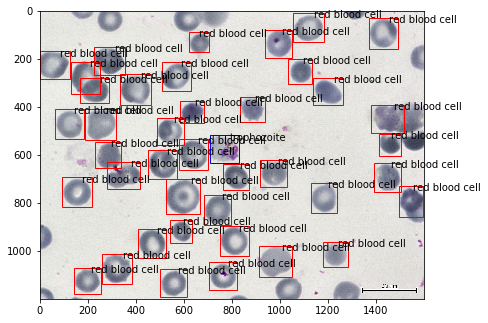

In [8]:
#Ref- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('training_images/01b99da8-b66b-464b-a7ee-1cadab8db18b.png')
plt.imshow(image)

for _,row in df_train[df_train.img_name == "training_images/01b99da8-b66b-464b-a7ee-1cadab8db18b.png"].iterrows():
    x_min = row.x_min
    x_max = row.x_max
    y_min = row.y_min
    y_max = row.y_max
    
    width = x_max - x_min
    height = y_max - y_min
    
    # assign different color to different classes of objects
    if row.label == 'red blood cell':
        edgecolor = 'r'
        ax.annotate('red blood cell', xy=(x_max-40,y_min+20))
    elif row.label == 'trophozoite':
        edgecolor = 'b'
        ax.annotate('trophozoite', xy=(x_max-40,y_min+20))
    elif row.label == 'schizont':
        edgecolor = 'y'
        ax.annotate('v', xy=(x_max-40,y_min+20))
    elif row.label == 'ring':
        edgecolor = 'g'
        ax.annotate('ring', xy=(x_max-40,y_min+20))
    elif row.label == 'gametocyte':
        edgecolor = 'c'
        ax.annotate('gametocyte', xy=(x_max-40,y_min+20))
    elif row.label == 'leukocyte':
        edgecolor = 'm'
        ax.annotate('leukocyte', xy=(x_max-40,y_min+20))

    
        
    # add bounding boxes to the image
    rect = patches.Rectangle((x_min,y_min), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

# the given image has all the rbc and only 1 trophozoite lets see what our final model predicts

In [7]:
final_model(['C:/Users/SKS/Desktop/img.png'])

Instructions for updating:
Colocations handled automatically by placer.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

read image
started predicting classes


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.49s/it]


{'red blood cell': 28, 'trophozoite': 2}

# Wow! Correct